<a href="https://colab.research.google.com/github/Somnath1998g/Projects/blob/main/Handwritten_digits_recognization_using_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten digits recognization using Neural Network

Let's begin by installing and importing the required modules and classes from torch, torchvision, numpy, and matplotlib.

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

We can download the data and create a PyTorch dataset using the `MNIST` class from `torchvision.datasets`.

In [2]:
dataset=MNIST(root='data/', download=True, transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 369276304.05it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 103534781.05it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 163577459.18it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 22598492.01it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Let's look at a couple of images from the dataset. The images are converted to PyTorch tensors with the shape `1x28x28` (the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects channels to be last dimension in an image tensor i.e., (width,height,channels), so we use the `permute` method to reorder the dimensions of the image.

image.shape: torch.Size([1, 28, 28])
label: 5


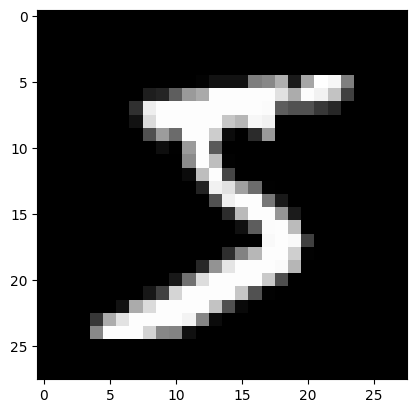

In [3]:
image, label= dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1,2,0), cmap='gray')
print('label:', label)

Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
batch_size=128

In [6]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's visualize a batch of data in a grid using the make_grid function from torchvision. We'll also use the .permute method on the tensor to move the channels to the last dimension, as expected by matplotlib.

images.shape: torch.Size([128, 1, 28, 28])


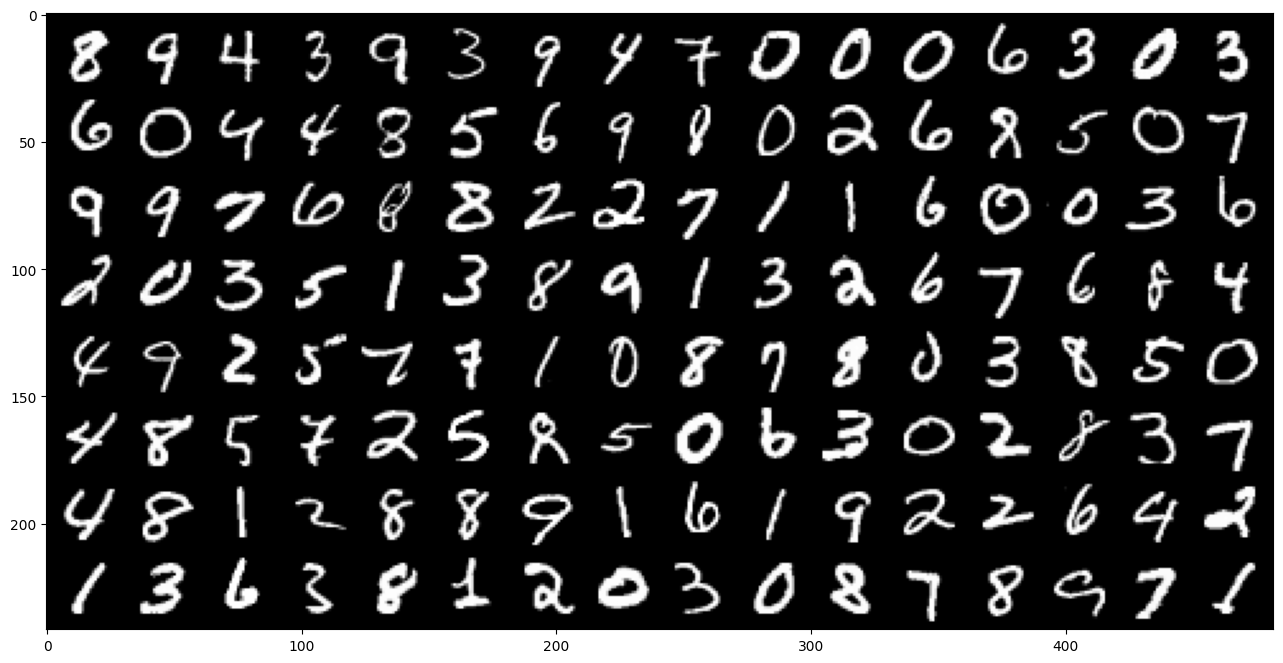

In [9]:
for images, _ in train_loader:
  print('images.shape:', images.shape)
  plt.figure(figsize=(16,8))
  plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
  break

First, let's create a batch of inputs tensors. We'll flatten the 1x28x28 images into vectors of size 784, so they can be passed into an nn.Linear object.

In [10]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a nn.Linear object, which will serve as our hidden layer. We'll set the size of the output from the hidden layer to 32.

In [11]:
input_size = inputs.shape[-1]
hidden_size = 32

In [13]:
layer1 = nn.Linear(input_size, hidden_size)
inputs.shape

torch.Size([128, 784])

In [15]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


## Model
We are now ready to define our model. we'll create a neural network with one hidden layer.

In [17]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We also need to define an `accuracy` function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in `validation_step` above.

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We'll create a model that contains a hidden layer with 32 activations.

In [19]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [20]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset and pass them into our model.

In [21]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3075413703918457
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.2056,  0.0824,  0.1569,  0.0089, -0.0565,  0.1425,  0.0284, -0.1994,
         -0.0253,  0.0655],
        [ 0.1509,  0.2086,  0.2186,  0.0346, -0.1719,  0.2680, -0.0118, -0.3004,
          0.0236,  0.0888]])


## Training the Model
We'll define two functions: fit and evaluate to train the model using gradient descent and evaluate its performance on the validation set.

In [31]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [32]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
#to_device(model, device)

In [33]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3157384395599365, 'val_acc': 0.08486328274011612}]

Let's train the model for five epochs and look at the results. We can use a relatively high learning rate of 0.5.

In [34]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2270, val_acc: 0.9324
Epoch [1], val_loss: 0.2032, val_acc: 0.9392
Epoch [2], val_loss: 0.1836, val_acc: 0.9430
Epoch [3], val_loss: 0.1469, val_acc: 0.9563
Epoch [4], val_loss: 0.1286, val_acc: 0.9619


In [35]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1162, val_acc: 0.9640
Epoch [1], val_loss: 0.1151, val_acc: 0.9662
Epoch [2], val_loss: 0.1149, val_acc: 0.9649
Epoch [3], val_loss: 0.1125, val_acc: 0.9675
Epoch [4], val_loss: 0.1140, val_acc: 0.9651


We can now plot the losses & accuracies to study how the model improves over time.

Text(0.5, 1.0, 'Loss vs. No. of Epochs')

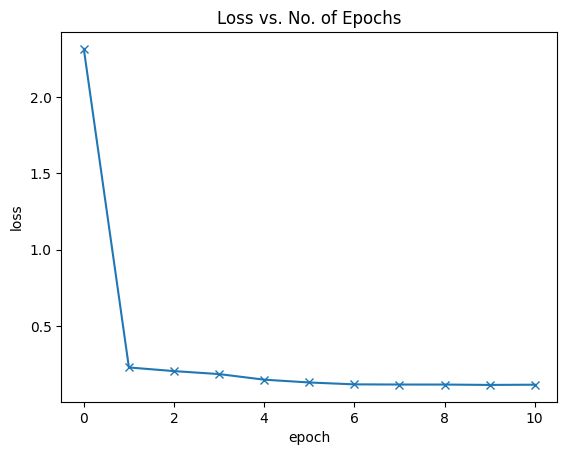

In [37]:
losses=[x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of Epochs')

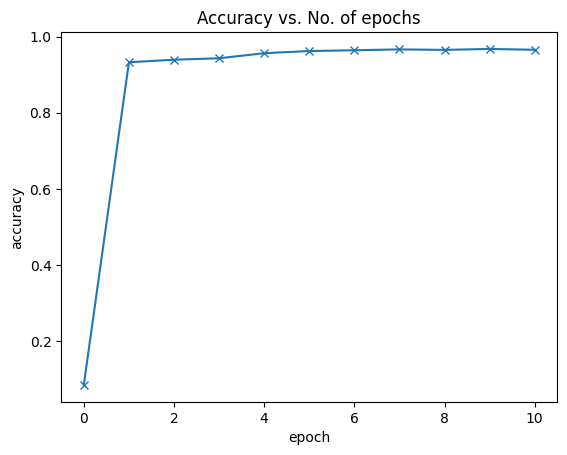

In [38]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Here we get a good accuracy of 96% on the validation set.

## Testing with individual images

In [39]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [41]:
def predict_image(img, model):
    xb = (img.unsqueeze(0))
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


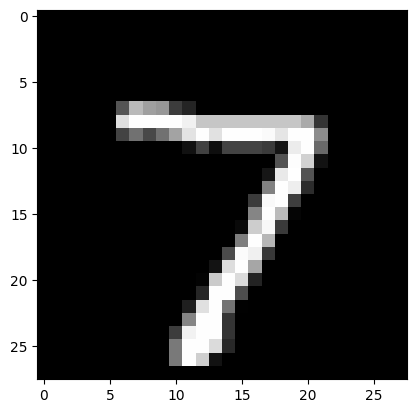

In [42]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


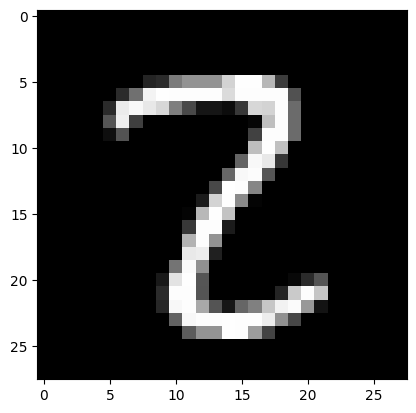

In [43]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [44]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10291413217782974, 'val_acc': 0.969921886920929}